# Sentiment based product recommendation system

## STEP 1: Trained NLP model for sentiment analysis

### Data understanding

#### Import the libraries

In [1]:
import random
import string
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
review_df = pd.read_csv("/kaggle/input/product-reviews/Product review dataset.csv", encoding='utf-8')
review_df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [3]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [4]:
print("Number of rows: " ,len(review_df))
print("Number of columns: " ,len(review_df.columns))

Number of rows:  30000
Number of columns:  15


Totally there are 3000 rows, 15 columns in the dataset.

#### Let's see if there are any null values in the dataset

In [5]:
100*review_df.isnull().mean()

id                       0.000000
brand                    0.000000
categories               0.000000
manufacturer             0.470000
name                     0.000000
reviews_date             0.153333
reviews_didPurchase     46.893333
reviews_doRecommend      8.566667
reviews_rating           0.000000
reviews_text             0.000000
reviews_title            0.633333
reviews_userCity        93.570000
reviews_userProvince    99.433333
reviews_username         0.210000
user_sentiment           0.003333
dtype: float64

##### These columns have high percentage of null values, better to drop them -> 'reviews_didPurchase','reviews_userCity','reviews_userProvince'

In [6]:
columns_to_drop=['reviews_didPurchase','reviews_userCity','reviews_userProvince']
review_df.drop(columns_to_drop, inplace=True, axis=1)

In [7]:
review_df.nunique()

id                       271
brand                    214
categories               270
manufacturer             227
name                     271
reviews_date            6857
reviews_doRecommend        2
reviews_rating             5
reviews_text           27282
reviews_title          18535
reviews_username       24914
user_sentiment             2
dtype: int64

##### As we can see above, there are no columns with single value.

In [8]:
review_df.head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,NaN,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


#### Handling the null values in the dataset review_df

In [9]:
# A function to check for the null values in the columns

def null_value_check(data_set):
    null_value = 100*data_set.isnull().mean()
    unique_value=data_set.nunique()
    summary_df=pd.DataFrame({'Null values': null_value, 'Unique values': unique_value})
    return summary_df.sort_values('Null values', ascending=False)

In [10]:
null_value_check(review_df)

,Null values,Unique values
reviews_doRecommend,8.566667,2
reviews_title,0.633333,18535
manufacturer,0.470000,227
reviews_username,0.210000,24914
reviews_date,0.153333,6857
user_sentiment,0.003333,2
id,0.000000,271
brand,0.000000,214
categories,0.000000,270
name,0.000000,271


##### Lets check each of these columns and handle the values

**COLUMN: reviews_doRecommend**

In [11]:
print(review_df['reviews_doRecommend'].value_counts(1))

reviews_doRecommend
True     0.943493
False    0.056507
Name: proportion, dtype: float64


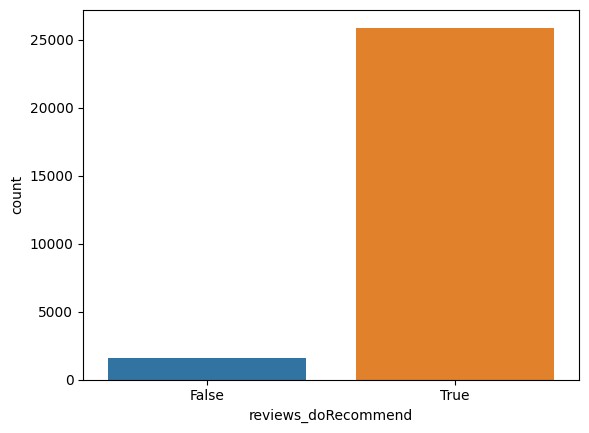

In [12]:
sns.countplot(x= review_df['reviews_doRecommend'])
plt.show()

##### Since the column has 94% True value, it won't be a very useful column for our training, so we can **drop it**

In [13]:
review_df.drop(columns='reviews_doRecommend', inplace=True)

In [14]:
null_value_check(review_df)

,Null values,Unique values
reviews_title,0.633333,18535
manufacturer,0.470000,227
reviews_username,0.210000,24914
reviews_date,0.153333,6857
user_sentiment,0.003333,2
id,0.000000,271
brand,0.000000,214
categories,0.000000,270
name,0.000000,271
reviews_rating,0.000000,5


**COLUMN: reviews_title**

##### Since it an important column for analysis and the null value percentage is quite less- 0.63%, we can remove the rows containing the null values

In [15]:
review_df.shape

(30000, 11)

In [16]:
clean_df=review_df[~review_df.reviews_title.isna()]
clean_df.shape

(29810, 11)

In [17]:
null_value_check(clean_df)

,Null values,Unique values
manufacturer,0.472996,213
reviews_username,0.207984,24788
reviews_date,0.154311,6711
user_sentiment,0.003355,2
categories,0.000000,252
id,0.000000,252
brand,0.000000,199
reviews_rating,0.000000,5
name,0.000000,252
reviews_title,0.000000,18535


**COLUMN: manufacturer**


In [18]:
# Checking if a single manufacturer supplies to multiple brands

manufacturer_brand_counts = clean_df.groupby('manufacturer')['brand'].nunique()

manufacturers_multiple_brands = manufacturer_brand_counts[manufacturer_brand_counts > 1]
manufacturers_multiple_brands

manufacturer
120                          3
Dr Pepper/Seven Up, Inc      2
Frito-Lay                    3
GENERAL MILLS SALES, INC.    3
Generic                      4
L'oreal Paris                2
Lions Gate                   2
P&G                          2
Reckitt Benckiser            3
UNILEVER                     2
Unilever                     2
Warner Home Video            2
Name: brand, dtype: int64

In [19]:
# Checking the number of null values in the manufacturer column
len(clean_df[clean_df['manufacturer'].isna()])

141

##### As we can see from above that there are manufacturers that supply to multiple brands. There could be scenarios wherin for one brand the sentiment is positive and for another it could be negative. Hence to avoid confusion during the model training, it is best to **drop this column**

In [20]:
clean_df= clean_df.drop(columns='manufacturer')

In [21]:
null_value_check(clean_df)

,Null values,Unique values
reviews_username,0.207984,24788
reviews_date,0.154311,6711
user_sentiment,0.003355,2
id,0.000000,252
brand,0.000000,199
categories,0.000000,252
reviews_rating,0.000000,5
name,0.000000,252
reviews_title,0.000000,18535
reviews_text,0.000000,27097


**COLUMN: reviews_username** column

##### It is important to know the users who have given the ratings to keep in mind that they have already purchased/ rated the item. So since the null value percentage is about- 0.20%  we can remove the null value rows.

In [22]:
clean_df=clean_df[~clean_df.reviews_username.isna()]

In [23]:
clean_df.shape

(29748, 10)

##### **COLUMN:reviews_date** won't provide much useful information hence we can drop it

In [24]:
clean_df.drop(columns="reviews_date", inplace=True)
clean_df.shape

(29748, 9)

In [25]:
null_value_check(clean_df)

,Null values,Unique values
user_sentiment,0.003362,2
id,0.000000,252
brand,0.000000,199
name,0.000000,252
categories,0.000000,252
reviews_rating,0.000000,5
reviews_text,0.000000,27042
reviews_title,0.000000,18490
reviews_username,0.000000,24788


##### **COLUMN: user_sentiment**

In [26]:
clean_df['user_sentiment'].value_counts(1)

user_sentiment
Positive    0.887888
Negative    0.112112
Name: proportion, dtype: float64

In [27]:
clean_df[clean_df['user_sentiment'].isna()]

,id,brand,categories,name,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,"Movies, Music & Books,Movies,Kids' & Family,Wa...",Planes: Fire Rescue (2 Discs) (includes Digita...,5,my kids absolutely loved this film so much tha...,a super hit with my children. they loved it!!??,7.87E+11,NaN


##### Since there is only one value of null user sentiment, and the majority of the reviews are of positive sentiment. Also from the reviews_text we can see that it is a positive sentiment hence, we can fill this null value as positive

In [28]:
clean_df['user_sentiment'] = clean_df['user_sentiment'].fillna('Positive')

In [29]:
null_value_check(clean_df)

,Null values,Unique values
id,0.0,252
brand,0.0,199
categories,0.0,252
name,0.0,252
reviews_rating,0.0,5
reviews_text,0.0,27042
reviews_title,0.0,18490
reviews_username,0.0,24788
user_sentiment,0.0,2


In [30]:
clean_df.shape

(29748, 9)

##### As seen above we have handled the null values for all the essential columns.

#### Exploratory data analysis

In [31]:
EDA_copy_df=clean_df.copy()

In [32]:
EDA_copy_df.shape

(29748, 9)

In [33]:
EDA_copy_df.columns

Index(['id', 'brand', 'categories', 'name', 'reviews_rating', 'reviews_text',
       'reviews_title', 'reviews_username', 'user_sentiment'],
      dtype='object')

In [34]:
#Converting the Positive user sentiment =0; Negative user sentiment = 1

EDA_copy_df['user_sentiment_binary'] = EDA_copy_df['user_sentiment'].replace({'Positive': 0, 'Negative': 1})
EDA_copy_df['user_sentiment_binary'].head()

/tmp/ipykernel_31/249438789.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  EDA_copy_df['user_sentiment_binary'] = EDA_copy_df['user_sentiment'].replace({'Positive': 0, 'Negative': 1})


0    0
1    0
2    0
3    1
4    1
Name: user_sentiment_binary, dtype: int64

##### Let's analyse column - **Brand**

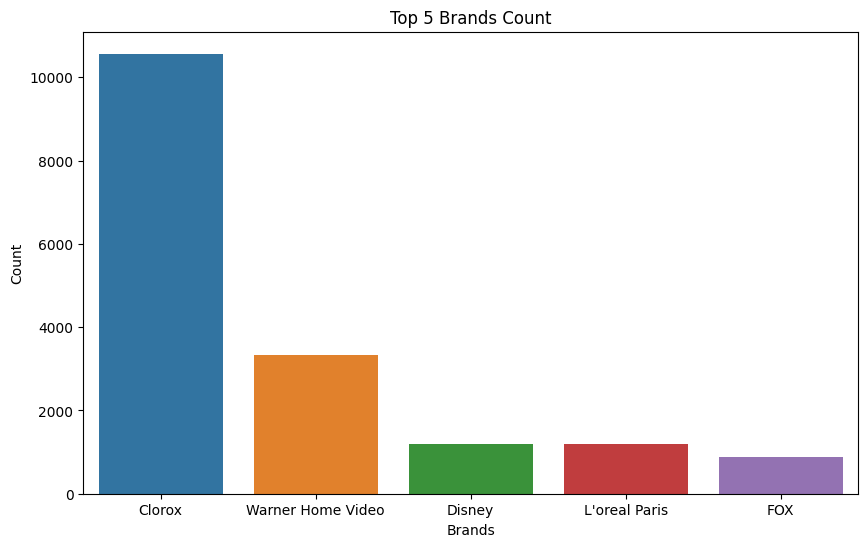

In [35]:
top_5_brands = EDA_copy_df['brand'].value_counts().head(5).index
filtered_df = EDA_copy_df[EDA_copy_df['brand'].isin(top_5_brands)]

plt.figure(figsize=(10,6))
sns.countplot(data=filtered_df, x='brand', order=top_5_brands)
plt.title('Top 5 Brands Count')
plt.xlabel('Brands')
plt.ylabel('Count')
plt.show()

##### We can see from the above graph that the **brand Clorox has the highest reviews in the dataset**

##### Let's now see the **sentiments of the users with the brand clorox**

<Figure size 1000x600 with 0 Axes>

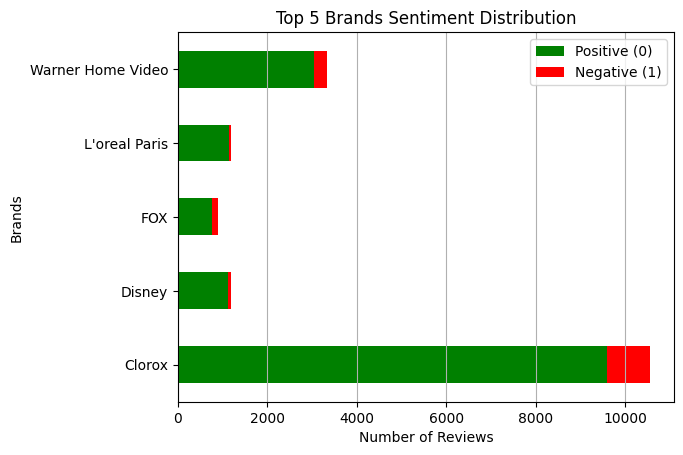

In [36]:
sentiment_counts = filtered_df.groupby(['brand', 'user_sentiment_binary']).size().unstack(fill_value=0)

plt.figure(figsize=(10,6))
sentiment_counts.plot(kind='barh', stacked=True, color=['green', 'red'])

plt.title('Top 5 Brands Sentiment Distribution')
plt.xlabel('Number of Reviews')
plt.ylabel('Brands')
plt.legend(['Positive (0)', 'Negative (1)'])
plt.grid(axis='x')
plt.show()

##### We can observe that out of the top 5 brands, all of them have almost positive sentiment. But **Clorox has the highest positive reviews** and also approximately 1000 negative sentiments

##### Let's analyze the column **Product name**

In [37]:
EDA_copy_df['name'].value_counts().head()

name
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                         8524
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                   3324
Clorox Disinfecting Bathroom Cleaner                                              2039
L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz    1186
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)               1140
Name: count, dtype: int64

In [38]:
short_labels = {
    "Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total": "Clorox Wipes",
    "Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd": "Godzilla 3D",
    "Clorox Disinfecting Bathroom Cleaner": "Clorox Bathroom Cleaner",
    "L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz": "Loreal Conditioner",
    "Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)": "Planes Fire Rescue"
}

EDA_copy_df['short_name'] = EDA_copy_df['name'].replace(short_labels)

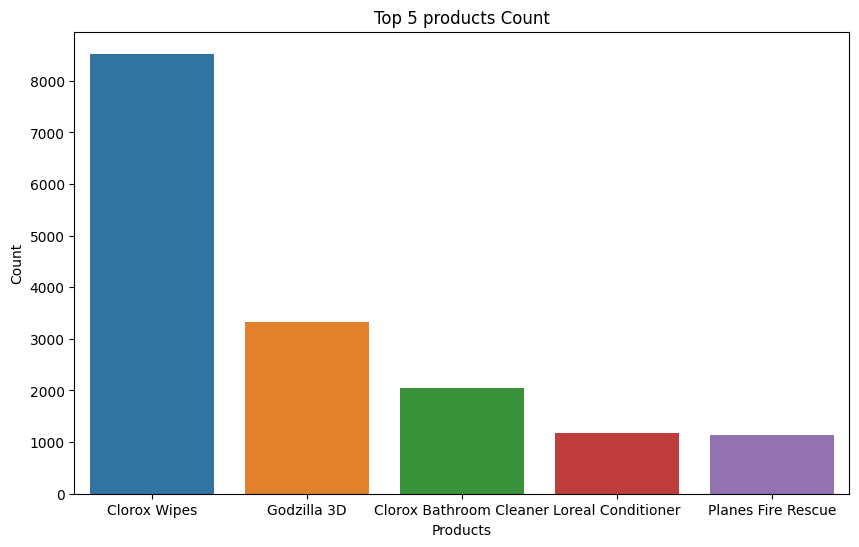

In [39]:
top_5_products = EDA_copy_df['short_name'].value_counts().head(5).index
filtered_df_new = EDA_copy_df[EDA_copy_df['short_name'].isin(top_5_products)]

plt.figure(figsize=(10,6))
sns.countplot(data=filtered_df_new, x='short_name', order=top_5_products)
plt.title('Top 5 products Count')
plt.xlabel('Products')
plt.ylabel('Count')
plt.show()

##### We can see that out of the top 5 reviewed products, **number 1 reviewed product is Clorox wipes**

<Figure size 1000x600 with 0 Axes>

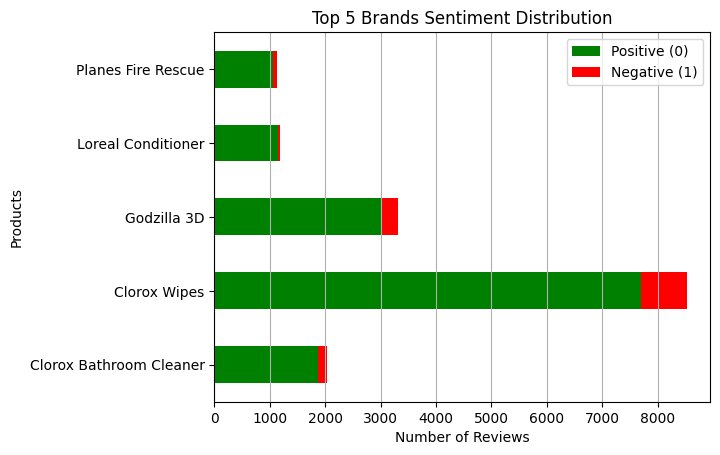

In [40]:
sentiment_counts = filtered_df_new.groupby(['short_name', 'user_sentiment_binary']).size().unstack(fill_value=0)

plt.figure(figsize=(10,6))
sentiment_counts.plot(kind='barh', stacked=True, color=['green', 'red'])

plt.title('Top 5 Brands Sentiment Distribution')
plt.xlabel('Number of Reviews')
plt.ylabel('Products')
plt.legend(['Positive (0)', 'Negative (1)'])
plt.grid(axis='x')
plt.show()

##### We can see that the **overall sentiment is positive for the top reviewed products**

##### Let's analyze the **reviews_rating**

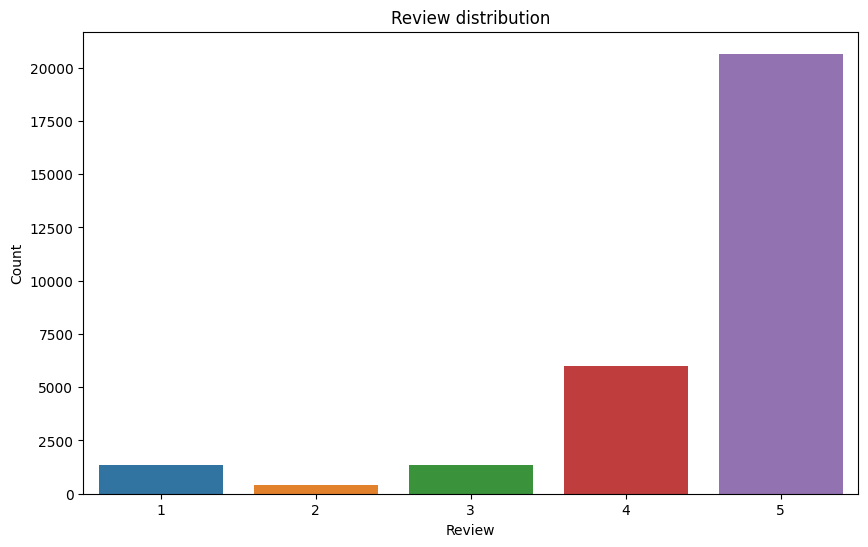

In [41]:
plt.figure(figsize=(10,6))
sns.countplot(data=EDA_copy_df, x='reviews_rating')
plt.title('Review distribution')
plt.xlabel('Review')
plt.ylabel('Count')
plt.show()

##### We can see from the above graph that the **majority of reviews are rated 5 stars**

##### Let's analyze the **user_sentiment** column

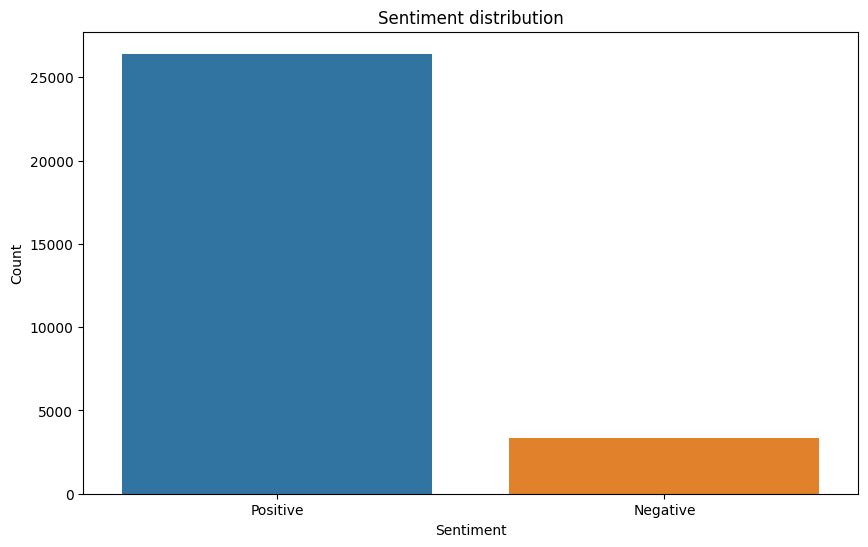

In [42]:
plt.figure(figsize=(10,6))
sns.countplot(data=EDA_copy_df, x='user_sentiment')
plt.title('Sentiment distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

##### We can see from the above graph that **the positive reviews are more than 25,000 whereas negative reviews are less than 5,000**, so there would be a class imbalance which we will be balancing in the training data set

##### The other columns:

##### * id-> unique product ids for each product
##### * reviews_text, reviews_title, reviews_username, categories-> these are text review columns that cannot be analyzed and is self explanatory


#### Text Pre-processing

In [43]:
clean_df.head()

,id,brand,categories,name,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


In [44]:
final_df=clean_df.copy()
final_df.shape

(29748, 9)

In [45]:
final_df['full_text']=final_df['reviews_text']+" "+final_df['reviews_title']
final_df.head()

,id,brand,categories,name,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,full_text
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive,i love this album. it's very good. more to the...
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive,Good flavor. This review was collected as part...
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,Good,dorothy w,Positive,Good flavor. Good
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative,I read through the reviews on here before look...
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative,My husband bought this gel for us. The gel cau...


In [46]:
print(final_df['full_text'][0])

i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy. Just Awesome


In [47]:
NLP_data_set=final_df[['full_text','user_sentiment']].copy()
NLP_data_set.head()

,full_text,user_sentiment
0,i love this album. it's very good. more to the...,Positive
1,Good flavor. This review was collected as part...,Positive
2,Good flavor. Good,Positive
3,I read through the reviews on here before look...,Negative
4,My husband bought this gel for us. The gel cau...,Negative


#### Type conversion

##### Type conversion of the full_text columns, as there is a possibility that the users could've entered numbers as well while giving the reviews. We have to convert the column to string to treat all the values in the column as a string.

In [48]:
NLP_data_set['full_text']=NLP_data_set['full_text'].astype(str)

In [49]:
#initialize stemmer and lemmatizer
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [50]:
#Function to preprocess the texts

def preprocess(document, stem=True):

    # lower case all the words
    document = document.lower()
    
    # remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    document = document.translate(translator)
    
    # tokenize the words
    words = word_tokenize(document)
    
    # remove all the stop words
    words = [word for word in words if word not in stopwords.words("english")]
    
    # bring the word to the root form
    if stem:
        words = [stemmer.stem(word) for word in words]
    else:
        words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]
    document = " ".join(words)

    return document

In [51]:
NLP_data_set['cleaned_text'] = NLP_data_set['full_text'].apply(lambda x: preprocess(x, stem=False))
NLP_data_set.head()

,full_text,user_sentiment,cleaned_text
0,i love this album. it's very good. more to the...,Positive,love album good hip hop side current pop sound...
1,Good flavor. This review was collected as part...,Positive,good flavor review collect part promotion good
2,Good flavor. Good,Positive,good flavor good
3,I read through the reviews on here before look...,Negative,read review look buy one couple lubricants ult...
4,My husband bought this gel for us. The gel cau...,Negative,husband buy gel us gel cause irritation felt l...


##### Let's check for the top 50 frequent words, in the NLP_data_set['cleaned_text']

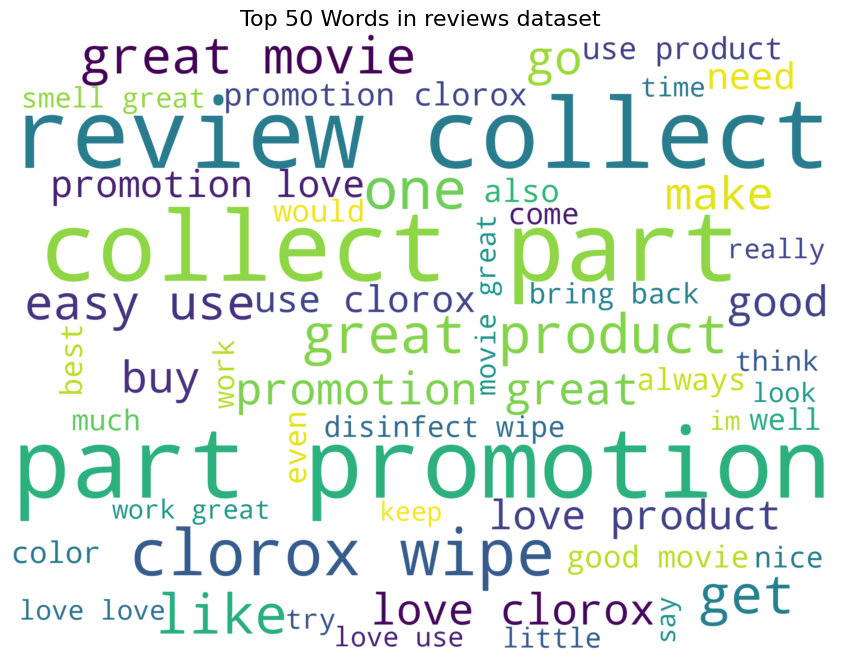

In [52]:
from wordcloud import WordCloud

stop_words = set(stopwords.words('english'))

wordcloud = WordCloud(
    stopwords=stop_words,
    background_color='white',
    width=2000,
    height=1500,
    max_words=50
).generate(' '.join(NLP_data_set['cleaned_text']))

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Top 50 Words in reviews dataset", fontsize=16)
plt.show()


#### Feature extraction

Using **TF-IDF vectorizer**

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_df=0.95,           # ignore terms that appear in >95% of documents
    min_df=2,              # only keep terms that appear in at least 2 documents
    ngram_range=(1,2)      # unigrams + bigrams
)

X = vectorizer.fit_transform(NLP_data_set['cleaned_text'])
y = NLP_data_set['user_sentiment']

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2) 

#### Class imbalance check

In [55]:
y_train.value_counts()

user_sentiment
Positive    21098
Negative     2700
Name: count, dtype: int64

##### We can see that there is a huge imbalance with majority in positive sentiment. Let's balance this class by oversampling technique, we will be **oversampling the minority class** by randomly choosing the minority class and duplicating the data to reach the class of highest group. Post this, we would be re-shuffling the data to keep it real.

In [56]:
from sklearn.utils import resample

#Combine X_train and y_train into a single DataFrame
train_data = pd.DataFrame.sparse.from_spmatrix(X_train)
train_data['label'] = y_train.values          

# Separate majority and minority classes
positive_sentiment = train_data[train_data['label'] == 'Positive']
negative_sentiment = train_data[train_data['label'] == 'Negative']

# Oversample minority class (negative)
negative_oversampled = resample(
    negative_sentiment, 
    replace=True,          
    n_samples=len(positive_sentiment),  
    random_state=42       
)

# Combine back
balanced_train_data = pd.concat([positive_sentiment, negative_oversampled])

# Shuffle the data
balanced_train_data = balanced_train_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Separate X and y again
X_train_balanced = balanced_train_data.drop('label', axis=1)
y_train_balanced = balanced_train_data['label']

##### Let's count the labels in the train set to check if the class imbalance still exists

In [57]:
y_train_balanced.value_counts()

label
Positive    21098
Negative    21098
Name: count, dtype: int64

##### We can see that the classes are balanced now.

### Training the model

### **Approach 1: Logistic Regression**

In [58]:
from sklearn.linear_model import LogisticRegression

Logistic_regression_model = LogisticRegression(random_state=42, solver='liblinear', class_weight='balanced')
Logistic_regression_model.fit(X_train_balanced, y_train_balanced)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

In [59]:
y_pred = Logistic_regression_model.predict(X_test)

### Evaluation of the model- Logistic regression

In [60]:
# Function to evaluate the model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

def model_results(model_name,y_test, y_pred):
   accuracy = accuracy_score(y_test, y_pred)
   precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
   recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
   f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
   
   results = {
        'Model Name': model_name,
        'Accuracy': round(accuracy,2),
        'Precision': round(precision,2),
        'Recall': round(recall,2),
        'F1 Score': round(f1,2)
        }
   return results

In [61]:
log_reg_results= model_results('Logistic regression model', y_test, y_pred)
log_reg_results

{'Model Name': 'Logistic regression model',
 'Accuracy': 0.89,
 'Precision': 0.92,
 'Recall': 0.89,
 'F1 Score': 0.9}

#### Observations:

We can see that the model is having a good accuracy.

In [62]:
# Function to check the prediction of the sentiment
def logistic_regression_check(input_sentence):
    # Step 1: Preprocess
    cleaned_sentence = preprocess(input_sentence, stem=False)
    
    # Step 2: Vectorize
    X_input = vectorizer.transform([cleaned_sentence])
    
    # Step 3: Predict
    predicted_sentiment = Logistic_regression_model.predict(X_input)
    
    return ("Predicted Sentiment:", predicted_sentiment[0])


In [63]:
input_sentence = "I really loved the product! It was amazing."
logistic_regression_check(input_sentence)

('Predicted Sentiment:', 'Positive')

In [64]:
input_sentence="the product i received was wonderful in the beginning, but as days went by it was failing to functions as expected"
logistic_regression_check(input_sentence)

('Predicted Sentiment:', 'Negative')

### **Approach 2: XGBOOST Classifier**

In [65]:
# We must label encode the values in the y column, i.e Positive, Negative
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

# Fit and transform the y columns
y_train_balanced_encoded = le.fit_transform(y_train_balanced)
y_test_encoded = le.transform(y_test)

In [66]:
from xgboost import XGBClassifier
from scipy.sparse import csr_matrix

X_train_balanced_sparse = csr_matrix(X_train_balanced.sparse.to_coo())

xgb_model = XGBClassifier(
    random_state=42,
    use_label_encoder=True,
    eval_metric='logloss'
)

XGB_classifier_model= xgb_model.fit(X_train_balanced_sparse, y_train_balanced_encoded)

In [67]:
y_pred = XGB_classifier_model.predict(X_test)


### Evaluation of the model- XGBOOST CLASSIFIER

In [68]:
xg_boost= model_results("XGB_classifier_model", y_test_encoded, y_pred)
xg_boost

{'Model Name': 'XGB_classifier_model',
 'Accuracy': 0.87,
 'Precision': 0.92,
 'Recall': 0.87,
 'F1 Score': 0.89}

#### Almost same as linear regression model

### **Approach 3: Decision Tree**

In [69]:
from sklearn.tree import DecisionTreeClassifier
from scipy.sparse import csr_matrix

dt_model = DecisionTreeClassifier(
    random_state=42, 
    criterion='gini',
    max_depth=10, 
    min_samples_leaf=6, 
    max_features=None
)

X_train_balanced_sparse = csr_matrix(X_train_balanced.sparse.to_coo())

Decision_Tree_classifier_model= dt_model.fit(X_train_balanced_sparse, y_train_balanced_encoded)

In [70]:
y_pred = dt_model.predict(X_test)

### Evaluation of the model- DECISION TREE CLASSIFIER

In [71]:
dt_model= model_results("Decision tree model", y_test_encoded, y_pred)
dt_model

{'Model Name': 'Decision tree model',
 'Accuracy': 0.81,
 'Precision': 0.88,
 'Recall': 0.81,
 'F1 Score': 0.83}

### Choosing the best model 

In [72]:
results_list = [log_reg_results, xg_boost, dt_model]

result_df = pd.DataFrame(results_list)

print(result_df)

                  Model Name  Accuracy  Precision  Recall  F1 Score
0  Logistic regression model      0.89       0.92    0.89      0.90
1       XGB_classifier_model      0.87       0.92    0.87      0.89
2        Decision tree model      0.81       0.88    0.81      0.83


##### In comparison to the 3 models, we can see that the **Logistic regression model is the best performing model**. We can go ahead and use the same trained logistic regression model for sentiment classification.

#### Saving the Model 1- Logistic regression model

In [73]:
# import pickle

# f = open('sentiment_classifier.pickle','wb')
# pickle.dump(Logistic_regression_model,f)
# print('Classifier stored at', f.name)
# f.close()

In [74]:
# if we want to load the classifier:

# f=open("sentiment_classifier.pickle",'rb')
# loaded_classifier = pickle.load(f)
# f.close()


# Product recommendation system

#### Data preparation

In [75]:
df_recommendation = pd.read_csv("/kaggle/input/product-reviews/Product review dataset.csv", encoding='utf-8')
df_recommendation.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


In [76]:
df_recommendation.shape

(30000, 15)

##### What are the necessary columns required to build the model?
* id
* name
* reviews_rating
* reviews_username

In [77]:
reco_df = df_recommendation[['id', 'name', 'reviews_rating', 'reviews_username','reviews_text']]
reco_df.shape

(30000, 5)

In [78]:
reco_df.head()

,id,name,reviews_rating,reviews_username,reviews_text
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,i love this album. it's very good. more to the...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Good flavor. This review was collected as part...
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Good flavor.
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,rebecca,I read through the reviews on here before look...
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,walker557,My husband bought this gel for us. The gel cau...


In [79]:
null_value_check(reco_df)

,Null values,Unique values
reviews_username,0.21,24914
id,0.00,271
name,0.00,271
reviews_rating,0.00,5
reviews_text,0.00,27282


In [80]:
print("Number of null values in Column - reviews_username is: ",reco_df['reviews_username'].isna().sum())

Number of null values in Column - reviews_username is:  63


In [81]:
reco_df = reco_df [~reco_df.reviews_username.isna()]

In [82]:
reco_df.shape

(29937, 5)

In [83]:
null_value_check(reco_df)

,Null values,Unique values
id,0.0,271
name,0.0,271
reviews_rating,0.0,5
reviews_username,0.0,24914
reviews_text,0.0,27227


In [84]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(reco_df, test_size=0.30, random_state=31)

In [85]:
print(train.shape)
print(test.shape)

(20955, 5)
(8982, 5)


In [86]:
train.head()

,id,name,reviews_rating,reviews_username,reviews_text
5704,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),4,dwof,"Loved this movie, and the cast is great. Seein..."
12549,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,josie225,"I always use clorox wipes, they clean like no ..."
8534,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,mellin1,I luv Clorox wipes..I keep these behind our to...
5671,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),4,jerry64gd,Funny movie with decent action. Love the Marvi...
21698,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,augale,Why did you change this product I am now looki...


In [87]:
# Let's create a pivot table

df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(0)

df_pivot.head(3)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating dummy train & dummy test dataset
These dataset will be used for prediction 
- Dummy train will be used later for prediction of the products which has not been rated by the user. To ignore the products rated by the user, we will mark it as 0 during prediction. The products not rated by user is marked as 1 for prediction in dummy train dataset. 

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the products rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [88]:
dummy_train = train.copy()

In [89]:
# The products not rated by user is marked as 1 for prediction. 

dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [90]:
# Converting the dummy_train into a pivot table

dummy_train = dummy_train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(1)

In [91]:
dummy_train.head(3)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### MODEL 1: User based recommendation system 

##### Let's calculate adjusted cosine similarity

**Adjusted Cosine Similarity removes user bias by:**


**Subtracting each user’s average rating before calculating cosine similarity.So we only compare the relative preference for items, not the absolute ratings.**



In [92]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [93]:
df_subtracted.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,...,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686
01impala,-0.011765,-0.011765,-0.011765,-0.011765,-0.011765,-0.011765,-0.011765,-0.011765,-0.011765,-0.011765,...,-0.011765,-0.011765,-0.011765,-0.011765,-0.011765,-0.011765,-0.011765,-0.011765,-0.011765,-0.011765
02dakota,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,...,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608
02deuce,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,...,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686,-0.015686
06stidriver,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,...,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608,-0.019608


##### Now let's calculate the **cosine similarities** between the users

In [94]:
from sklearn.metrics.pairwise import pairwise_distances

In [95]:
# Creating the User Similarity Matrix using pairwise_distance function.

user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[ 1.         -0.00498586 -0.00498586 ... -0.00498586 -0.00498586
  -0.00498586]
 [-0.00498586  1.          1.         ... -0.00393701 -0.00393701
  -0.00393701]
 [-0.00498586  1.          1.         ... -0.00393701 -0.00393701
  -0.00393701]
 ...
 [-0.00498586 -0.00393701 -0.00393701 ...  1.          1.
   1.        ]
 [-0.00498586 -0.00393701 -0.00393701 ...  1.          1.
   1.        ]
 [-0.00498586 -0.00393701 -0.00393701 ...  1.          1.
   1.        ]]


#### Prediction of the user ratings

In [96]:
# We can see from the above correlations, there are negative correlations as well. 
#Only the users positive correlations will have more in common, so ignoring correlations below 0

user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       [0., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.]])

##### Rating predicted for the user is the weighted sum of correlation with the product rating

In [97]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 2.23566464, 2.65323457,
        0.        ],
       [0.        , 0.        , 5.47511267, ..., 1.59374136, 0.        ,
        0.        ],
       [0.        , 0.        , 5.47511267, ..., 1.59374136, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.44188335, ..., 0.        , 0.        ,
        2.87536372],
       [0.        , 0.        , 0.44188335, ..., 0.        , 0.        ,
        2.87536372],
       [0.        , 0.        , 0.44188335, ..., 0.        , 0.        ,
        2.87536372]])

In [98]:
user_predicted_ratings.shape

(18212, 255)

##### Finally, we have the ratings by the users, but it both already rated and not rated datasets. We have to ignore the already rated products by multiplying the user_predicted_ratings with the dummy_train

In [99]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.000000,12.613258,0.0,0.0,0.0,2.542013,0.000000,0.00000,...,2.253035,0.485434,0.0,2.347911,0.000000,0.0,3.135863,2.235665,2.653235,0.000000
01impala,0.0,0.0,5.475113,26.105455,0.0,0.0,0.0,0.000000,0.000000,1.75277,...,5.895157,3.805217,0.0,0.000000,1.529997,0.0,0.000000,1.593741,0.000000,0.000000
02dakota,0.0,0.0,5.475113,26.105455,0.0,0.0,0.0,0.000000,0.000000,1.75277,...,5.895157,3.805217,0.0,0.000000,1.529997,0.0,0.000000,1.593741,0.000000,0.000000
02deuce,0.0,0.0,5.475113,26.105455,0.0,0.0,0.0,0.000000,0.000000,1.75277,...,5.895157,3.805217,0.0,0.000000,1.529997,0.0,0.000000,1.593741,0.000000,0.000000
06stidriver,0.0,0.0,0.441883,14.576143,0.0,0.0,0.0,6.648202,3.528567,0.00000,...,0.000000,0.000000,0.0,3.528567,0.000000,0.0,2.077788,0.000000,0.000000,2.875364


### Finding the top 5 recommendation for the *user*

In [100]:
# function to recommend product to user based on user based recommendation system
def recommend_product_user(user_id):
    user_input = user_id
    search = user_final_rating.loc[user_input].sort_values(ascending=False)[0:10]
    search = search.reset_index()
    search.columns = ['id', 'Predicted_Score']

    main_df_unique = reco_df.drop_duplicates(subset='id')
    merged_df = pd.merge(search, main_df_unique[['id', 'name']], on='id', how='left')
    return merged_df   

In [101]:
recommend_product_user("02dakota")

,id,Predicted_Score,name
0,AVpfRTh1ilAPnD_xYic2,115.227509,Planes: Fire Rescue (2 Discs) (includes Digita...
1,AVpe41TqilAPnD_xQH3d,110.851636,Mike Dave Need Wedding Dates (dvd + Digital)
2,AVpf0eb2LJeJML43EVSt,107.625309,The Resident Evil Collection 5 Discs (blu-Ray)
3,AVpe59io1cnluZ0-ZgDU,70.108484,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...
4,AVpf2tw1ilAPnD_xjflC,67.180254,Red (special Edition) (dvdvideo)
5,AVpf3VOfilAPnD_xjpun,63.208355,Clorox Disinfecting Wipes Value Pack Scented 1...
6,AVpfPnrU1cnluZ0-g9rL,30.149708,Stargate (ws) (ultimate Edition) (director's C...
7,AV1YGDqsGV-KLJ3adc-O,26.105455,Windex Original Glass Cleaner Refill 67.6oz (2...
8,AVpf0thK1cnluZ0-r8vR,24.782112,100:Complete First Season (blu-Ray)
9,AVpfD9xTLJeJML431ig2,24.422358,There's Something About Mary (dvd)


### Evaluation - User based recommendation system

##### Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the products already rated by the user insead of predicting it for the products not rated by the user. 

In [102]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1976, 5)

In [103]:
common.head()

,id,name,reviews_rating,reviews_username,reviews_text
21169,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,jjjj,What happened The old formula was one of the b...
8538,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,jygibri,"it works great, i love the smell it keeps my h..."
18735,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,4,jel08,I love the smell that you can clean and disinf...
22417,AVpfOmKwLJeJML435GM7,Clear Scalp & Hair Therapy Total Care Nourishi...,1,elena79,I have been using Clear products for over 3 ye...
19297,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,angc,I love using these wipes whether at home or at...


In [104]:
# convert common into the user-product matrix.
common_user_based_matrix = common.pivot_table(
    index='reviews_username', 
    columns='id', 
    values='reviews_rating'
)

common_user_based_matrix.head(2)

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1h6Gu0glJLPUi8IjA_,...,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123charlie,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
# Convert the user_correlation matrix into dataframe.

user_correlation_df = pd.DataFrame(user_correlation)

In [106]:
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18202,18203,18204,18205,18206,18207,18208,18209,18210,18211
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948559,0.0,...,0.0,0.0,0.312863,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,1.0,1.0,1.0


##### We have to add indexes to the user_correlation_df from df_subtracted dataframe

In [107]:
user_correlation_df['userId'] = df_subtracted.index
user_correlation_df.set_index('userId',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18202,18203,18204,18205,18206,18207,18208,18209,18210,18211
userId,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.948559,0.0,...,0.0,0.0,0.312863,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,1.0,1.0,1.0


##### Have to perform 3 actions on the correlation dataframe, create new dataframes such that they have:
- a. Only rows same as the train data.
- b. Only columns same as train data.
- c. Rows and columns as train data.

In [108]:
list_name = common.reviews_username.tolist()
user_correlation_df.columns = df_subtracted.index.tolist()

user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [109]:
user_correlation_df_1.shape

(1660, 18212)

In [110]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [111]:
user_correlation_df_3 = user_correlation_df_2.T

In [112]:
user_correlation_df_3.head()

,1234,123charlie,37f5p,4cloroxl,50cal,7.87E+11,aac06002,abbey,abbi,abby,...,yesseniaw22,yeya,ygtz,yummy,zapman,zburt5,zebras,zippy,zitro,zxcsdfd
userId,,,,,,,,,,,,,,,,,,,,,
1234,1.000000,0.527163,0.0,0.0,0.527163,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.368675,0.660655,0.0
123charlie,0.527163,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
37f5p,0.000000,0.000000,1.0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0
4cloroxl,0.000000,0.000000,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.000000,0.000000,1.0
50cal,0.527163,1.000000,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0


In [113]:
user_correlation_df_3[user_correlation_df_3<0]=0

In [114]:
common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[3.62789957, 3.95656969, 0.        , ..., 2.42589056, 1.62312895,
        0.        ],
       [0.        , 3.96533622, 0.        , ..., 0.74621081, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.43734014, 1.19793458, 0.91465036, ..., 0.        , 2.18670071,
        0.        ],
       [5.        , 2.82285386, 0.        , ..., 3.07621601, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 5.        , 0.        ,
        0.        ]])

In [115]:
# Creating a dummy_test dataframe, with rating mappingss opposite to dummy_train

dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(
    index='reviews_username', 
    columns='id', 
    values='reviews_rating').fillna(0)

In [116]:
dummy_test.shape

(1660, 127)

#### Predicting the ratings for test data

In [117]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [118]:
common_user_predicted_ratings.head()

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1h6Gu0glJLPUi8IjA_,...,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfs0tUilAPnD_xgqN2,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37f5p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50cal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Evaluating the User based recommendation system
##### Calculating the RMSE for only the products rated by user. For RMSE, normalising the rating to (1,5) range.

In [119]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [120]:
common_ = common.pivot_table(
    index='reviews_username', 
    columns='id', 
    values='reviews_rating'
)

In [121]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.1234843875601426


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


##### The **RMSE score** for User based product recommendation system is - **2.123**

### MODEL 2: Item based recommendation system 

##### Taking the transpose of the rating matrix to normalize the rating around the mean for different Product ID. In the user based similarity, we had taken mean for each user instead of each product. 

In [122]:
df_pivot_item = train.pivot_table(
    index='reviews_username', 
    columns='id', 
    values='reviews_rating'
).T

df_pivot_item.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

reviews_username,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,...,zowie,zozo0o,zpalma,zsazsa,zt313,zuttle,zwithanx,zxcsdfd,zyiah4,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Normalising the product rating for each product using the Adujsted Cosine

In [123]:
mean_item = np.nanmean(df_pivot_item, axis=1)
df_subtracted_item = (df_pivot_item.T-mean_item).T

In [124]:
df_subtracted_item.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

reviews_username,00sab00,01impala,02dakota,02deuce,06stidriver,08dallas,09mommy11,1.11E+24,1085,10ten,...,zowie,zozo0o,zpalma,zsazsa,zt313,zuttle,zwithanx,zxcsdfd,zyiah4,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Finding the cosine similarity using pairwise distances approach

In [125]:
# Item Similarity Matrix

item_correlation = 1 - pairwise_distances(df_subtracted_item.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [126]:
# Filtering the positive correlations

item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

#### Prediction of the item ratings

In [127]:
item_predicted_ratings = np.dot((df_pivot_item.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.00600224, 0.06201728,
        0.        ],
       [0.        , 0.        , 0.01254045, ..., 0.00108461, 0.        ,
        0.        ],
       [0.        , 0.        , 0.02090075, ..., 0.00180769, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00644332],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00644332],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00515466]])

In [128]:
item_predicted_ratings.shape

(18212, 255)

In [129]:
dummy_train.shape

(18212, 255)

##### Filtering the rating only for the products not rated by the user for recommendation

In [130]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.011345,0.001677,0.0,0.010336,0.0,0.0,0.033075,0.006002,0.062017,0.000000
01impala,0.0,0.0,0.012540,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.004564,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.001085,0.000000,0.000000
02dakota,0.0,0.0,0.020901,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.007607,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.001808,0.000000,0.000000
02deuce,0.0,0.0,0.016721,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.006085,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.001446,0.000000,0.000000
06stidriver,0.0,0.0,0.000000,0.000454,0.0,0.0,0.0,0.001731,0.001915,0.000000,...,0.000000,0.000000,0.0,0.003187,0.0,0.0,0.000000,0.000000,0.000000,0.006443


### Finding the top 5 recommendation for the *user* with item based recommendation

In [131]:
# function to recommend product to user based on item based recommendation system
def recommend_product_item(user_id):
    user_input = user_id
    search = item_final_rating.loc[user_input].sort_values(ascending=False)[0:10]
    search = search.reset_index()
    search.columns = ['id', 'Predicted_Score']

    main_df_unique = reco_df.drop_duplicates(subset='id')
    merged_df = pd.merge(search, main_df_unique[['id', 'name']], on='id', how='left')
    return merged_df   

In [132]:
recommend_product_item("02dakota")

,id,Predicted_Score,name
0,AVpe8q4T1cnluZ0-afct,0.086113,"Newman's Own Organics Licorice Twist, Black 5oz"
1,AVpe_5U_ilAPnD_xSrxG,0.059206,Sea Gull Lighting Six Light Bath Sconce/vanity...
2,AVpe41TqilAPnD_xQH3d,0.045578,Mike Dave Need Wedding Dates (dvd + Digital)
3,AV1ZSp2uglJLPUi8IQFy,0.041865,"Cetaphil Gentle Skin Cleanser, 2oz"
4,AVpfOmKwLJeJML435GM7,0.036048,Clear Scalp & Hair Therapy Total Care Nourishi...
5,AVpfJcHuLJeJML433ZrY,0.029837,Equals (blu-Ray)
6,AVpfRTh1ilAPnD_xYic2,0.027343,Planes: Fire Rescue (2 Discs) (includes Digita...
7,AVpfQtEm1cnluZ0-hUpe,0.025843,Jolly Time Select Premium Yellow Pop Corn
8,AVpf7LysilAPnD_xkm9G,0.022634,Cuisinart174 Electric Juicer - Stainless Steel...
9,AV16khLE-jtxr-f38VFn,0.020901,K-Y Love Sensuality Pleasure Gel


### Evaluation - Item based recommendation system

##### Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the products already rated by the user insead of predicting it for the products not rated by the user. 

In [133]:
common_item =  test[test.id.isin(train.id)]
common_item.shape 

(8964, 5)

In [134]:
common_item.head()

,id,name,reviews_rating,reviews_username,reviews_text
21384,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,curlyd,I bought this gel that I have been using for o...
14483,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,prip,It's prefect and convenient for a fast clean. ...
21169,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,jjjj,What happened The old formula was one of the b...
25411,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,5,internetfreak69,"If you`ve are into monster movies, you have to..."
20351,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5,hb6851,Makes cleaning so much easier and smells great...


In [135]:
common_item_based_matrix = common_item.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating').T


In [136]:
common_item_based_matrix.shape

(203, 8348)

In [137]:
item_correlation_df = pd.DataFrame(item_correlation)

In [138]:
item_correlation_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,245,246,247,248,249,250,251,252,253,254
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013954,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.078102,0.0,0.0,0.0,0.0,0.0,0.0,0.001989,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [139]:
# Adding the index to the correlation df from df_subtracted_item

item_correlation_df['id'] = df_subtracted_item.index
item_correlation_df.set_index('id',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,...,245,246,247,248,249,250,251,252,253,254
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.013954,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.078102,0.0,0.0,0.0,0.0,0.0,0.0,0.001989,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


Have to perform 3 actions on the correlation dataframe, create new dataframes such that they have:
- a. Only rows same as the train data.
- b. Only columns same as train data.
- c. Rows and columns as train data.

In [140]:
list_name = common_item.id.tolist()

item_correlation_df.columns = df_subtracted_item.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]
item_correlation_df_3 = item_correlation_df_2.T

In [141]:
item_correlation_df_3.head()

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,...,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.013954,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003657,0.0,...,0.0,0.078102,0.0,0.0,0.0,0.0,0.0,0.001989,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [142]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02105944, 0.00045358, 0.00036287, ..., 0.00045358, 0.00018143,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00733409],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.10336214],
       [0.        , 0.00644332, 0.00515466, ..., 0.00644332, 0.00257733,
        0.        ]])

In [143]:
common_item_predicted_ratings.shape

(203, 8348)

##### Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train

In [144]:
dummy_test = common_item.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [145]:
common_item_predicted_ratings.head()

reviews_username,00dog3,0325home,1234,1234561,123cat123,123charlie,123numbers,127726,12cass12,1753,...,zombie,zombiedad80,zombiegirl22,zotox,zsarah,zubb,zulaa118,zxcsdfd,zxjki,zzdiane
id,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmBrdGV-KLJ3adewb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YmDL9vKc47QAVgr7_,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [146]:
common_ = common_item.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [147]:
X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:473: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:474: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)
/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:114: RuntimeWarning: invalid value encountered in less
  constant_mask = scale < 10 * np.finfo(scale.dtype).eps


In [148]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [149]:
rmse_item = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse_item)

3.5767040528289376


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


In [150]:
print("RMSE of User based recommendation system: ", rmse)
print("RMSE of Item based recommendation system: ", rmse_item)

RMSE of User based recommendation system:  2.1234843875601426
RMSE of Item based recommendation system:  3.5767040528289376


#### Therefore the **best recommendation model** using rmse evaluation is- **User based recommendation system** 

## Building Sentiment based reccomendation model 

- With logistic regression model for sentiment analysis
- With user-based recommendation system

In [151]:
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.000000,12.613258,0.0,0.0,0.0,2.542013,0.000000,0.00000,...,2.253035,0.485434,0.0,2.347911,0.000000,0.0,3.135863,2.235665,2.653235,0.000000
01impala,0.0,0.0,5.475113,26.105455,0.0,0.0,0.0,0.000000,0.000000,1.75277,...,5.895157,3.805217,0.0,0.000000,1.529997,0.0,0.000000,1.593741,0.000000,0.000000
02dakota,0.0,0.0,5.475113,26.105455,0.0,0.0,0.0,0.000000,0.000000,1.75277,...,5.895157,3.805217,0.0,0.000000,1.529997,0.0,0.000000,1.593741,0.000000,0.000000
02deuce,0.0,0.0,5.475113,26.105455,0.0,0.0,0.0,0.000000,0.000000,1.75277,...,5.895157,3.805217,0.0,0.000000,1.529997,0.0,0.000000,1.593741,0.000000,0.000000
06stidriver,0.0,0.0,0.441883,14.576143,0.0,0.0,0.0,6.648202,3.528567,0.00000,...,0.000000,0.000000,0.0,3.528567,0.000000,0.0,2.077788,0.000000,0.000000,2.875364


In [154]:
# Combining both the pipelines- logistic regression and user based product recommendation pipeline
def final_sentiment_based_recommendation(user_id):
    
    # Step 1: Recommend Top 20 Products
    
    user_input = user_id
    search = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
    search = search.reset_index()
    search.columns = ['id', 'Predicted_Score']
    
    main_df_unique = reco_df.drop_duplicates(subset='id')
    merged_df = pd.merge(search, main_df_unique[['id', 'name', 'reviews_rating', 'reviews_username', 'reviews_text']], on='id', how='left')
    
    # Step 2: Analyze Sentiments for each product
    
    sentiment_scores = []
    
    for idx, row in merged_df.iterrows():
        review_text = str(row['reviews_text'])
        
        # Preprocess the review
        cleaned_review = preprocess(review_text, stem=False)
        
        # Vectorize
        X_review = vectorizer.transform([cleaned_review])
        
        # Predict sentiment
        predicted_sentiment = Logistic_regression_model.predict(X_review)[0]
        
        # Optionally, you can assign 1 for Positive, 0 for Negative
        sentiment_score = 1 if predicted_sentiment == 'Positive' else 0
        sentiment_scores.append(sentiment_score)
    
    # Add sentiment score to merged_df
    merged_df['Sentiment_Score'] = sentiment_scores

    # Step 3: Select top 5 Products with best sentiment ---
    
    final_recommendations = merged_df.sort_values(by=['Sentiment_Score', 'Predicted_Score'], ascending=[False, False]).head(5)
    
    return final_recommendations[['id', 'name', 'Predicted_Score', 'Sentiment_Score']]


In [159]:
final_recommendations= final_sentiment_based_recommendation("02dakota")
final_recommendations

,id,name,Predicted_Score,Sentiment_Score
3,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,70.108484,1
5,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,63.208355,1
7,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2...,26.105455,1
8,AVpf0thK1cnluZ0-r8vR,100:Complete First Season (blu-Ray),24.782112,1
11,AVpf5olc1cnluZ0-tPrO,Chester's Cheese Flavored Puffcorn Snacks,20.095138,1


In [162]:
print(f"\nThe top 5 products to recommend based on sentiment and predicted score are:\n")
for index, row in final_recommendations.iterrows():
    print(f"Product Name: {row['name']}")


The top 5 products to recommend based on sentiment and predicted score are:

Product Name: My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Digital)
Product Name: Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total
Product Name: Windex Original Glass Cleaner Refill 67.6oz (2 Liter)
Product Name: 100:Complete First Season (blu-Ray)
Product Name: Chester's Cheese Flavored Puffcorn Snacks


Therefore, we can reccomend the following products to user- 02dakota